In [1]:
import warnings
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from influxdb_client.client.warnings import MissingPivotFunction
from influxdb_client import InfluxDBClient, Point, WriteOptions
import seaborn as sns
import time

In [2]:
# Reading Data from DB

# InfluxDB credentials and details
url = "http://kammeyer.uk:8086"
token = "9V1NYZbTXZkbf9H0Szf8Gl-dOaqrl97TmdC9gwNhxkRCgAcHR7jGSxnPtwHq2vBL-UOd607yPlROxlJAhRAwqw=="
org = "messme"

# Initialize InfluxDB Client
client = InfluxDBClient(url=url, token=token, org=org)

# Define the query for the 'energy' bucket
query = """
from(bucket: "co2")
  |> range(start: -1y)
  |> filter(fn: (r) => r._measurement == "co2_calculated")
  |> pivot(rowKey:["_time"], columnKey: ["_field"], valueColumn: "_value")
"""

# Fetch data into a DataFrame
start = time.time()
df = client.query_api().query_data_frame(query=query)
end = time.time()
print("Time taken to read the data is : ", end-start)
df.head()

Time taken to read the data is :  24.073877573013306


,result,table,_start,_stop,_time,_measurement,countryCode,carbonIntensity,fossilFuelPercentage
0,_result,0,2023-04-01 03:15:20.279802+00:00,2024-03-31 09:15:20.279802+00:00,2023-04-01 03:30:00+00:00,co2_calculated,DE,235.539123,28.736205
1,_result,0,2023-04-01 03:15:20.279802+00:00,2024-03-31 09:15:20.279802+00:00,2023-04-01 03:45:00+00:00,co2_calculated,DE,233.196951,28.611910
2,_result,0,2023-04-01 03:15:20.279802+00:00,2024-03-31 09:15:20.279802+00:00,2023-04-01 04:00:00+00:00,co2_calculated,DE,229.810343,28.161621
3,_result,0,2023-04-01 03:15:20.279802+00:00,2024-03-31 09:15:20.279802+00:00,2023-04-01 04:15:00+00:00,co2_calculated,DE,229.055334,27.892679
4,_result,0,2023-04-01 03:15:20.279802+00:00,2024-03-31 09:15:20.279802+00:00,2023-04-01 04:30:00+00:00,co2_calculated,DE,227.518912,27.496126


In [3]:
# drop extra columns
columns_to_drop = ['result', '_start', '_stop', '_measurement', 'countryCode', 'fossilFuelPercentage', 'table']
df = df.drop(columns=columns_to_drop, inplace=False)

# Set index
df['_time'] = pd.to_datetime(df['_time'])
df = df.set_index('_time')

# Sort the DataFrame by index
df = df.sort_index()

df = df[["carbonIntensity"]]

print(df)
nan_count = df.isna().sum()
print("df shape is : ", df.shape)
print("Number of NaN values in 'carbonIntensity' column:", nan_count)
df = df.fillna(method='ffill')
print("Filled values with ffill")

                           carbonIntensity
_time                                     
2023-04-01 03:30:00+00:00       235.539123
2023-04-01 03:45:00+00:00       233.196951
2023-04-01 04:00:00+00:00       229.810343
2023-04-01 04:15:00+00:00       229.055334
2023-04-01 04:30:00+00:00       227.518912
...                                    ...
2024-03-31 07:00:00+00:00        14.000000
2024-03-31 07:15:00+00:00        14.000000
2024-03-31 07:30:00+00:00        14.000000
2024-03-31 07:45:00+00:00        14.000000
2024-03-31 08:00:00+00:00        14.000000

[35022 rows x 1 columns]
df shape is :  (35022, 1)
Number of NaN values in 'carbonIntensity' column: carbonIntensity    0
dtype: int64
Filled values with ffill


In [4]:
import pandas as pd

def create_features(df):
    """
    Create time series features based on time series index.
    """
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['dayofmonth'] = df.index.day
    df['weekofyear'] = df.index.isocalendar().week

    # Add rolling mean and rolling standard deviation for a 7-day window
    df['rolling_mean'] = df['carbonIntensity'].rolling(window=7*24*4, min_periods=1).mean()
    df['rolling_std'] = df['carbonIntensity'].rolling(window=7*24*4, min_periods=1).std()
    
    # Add Exponential Moving Average (EMA)
    df['ema_12'] = df['carbonIntensity'].ewm(span=1.3, min_periods=1).mean()

    return df

In [5]:
# train, test and valiation split
result_with_more_features = create_features(df)
#print("result_with_more_features columns are : ", result_with_more_features) 

validation_size = 672
remaining_size = len(result_with_more_features) - validation_size

train_size = int(remaining_size * 0.85)
test_size = remaining_size - train_size

total_size = train_size + test_size + validation_size
if total_size > len(result_with_more_features):
    raise ValueError("Total size exceeds the length of the dataset.")

train, temp = result_with_more_features[:train_size], result_with_more_features[train_size:]
test, validation = temp[:test_size], temp[test_size:test_size + validation_size]

print("Train Shape is : ", train.shape)
print("Test Shape is : ", test.shape)
print("validation shape is : ", validation.shape)
print("validation index 0 is : ", validation.index[0])
print("validation index last is : ", validation.index[-1])

# Creating new column with values from previous row ( for column co2 ) - only for train and test sets
train['lag_1'] = train['carbonIntensity'].shift(1)
train['ema_12'] = train['carbonIntensity'].ewm(span=1.3, adjust=False).mean()
train = train.dropna() # you will have NaN for the first row for lag_1 column

test['lag_1'] = test['carbonIntensity'].shift(1)
test['ema_12'] = test['carbonIntensity'].ewm(span=1.3, adjust=False).mean()
test = test.dropna()

print("test columns are: ", test.columns)

Train Shape is :  (29197, 12)
Test Shape is :  (5153, 12)
validation shape is :  (672, 12)
validation index 0 is :  2024-03-24 08:00:00+00:00
validation index last is :  2024-03-31 08:00:00+00:00
test columns are:  Index(['carbonIntensity', 'hour', 'dayofweek', 'quarter', 'month', 'year',
       'dayofyear', 'dayofmonth', 'weekofyear', 'rolling_mean', 'rolling_std',
       'ema_12', 'lag_1'],
      dtype='object')


C:\Users\sahar\AppData\Local\Temp\ipykernel_28852\3725026666.py:25: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['lag_1'] = train['carbonIntensity'].shift(1)
C:\Users\sahar\AppData\Local\Temp\ipykernel_28852\3725026666.py:26: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  train['ema_12'] = train['carbonIntensity'].ewm(span=1.3, adjust=False).mean()
C:\Users\sahar\AppData\Local\Temp\ipykernel_28852\3725026666.py:29: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFr

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV


FEATURES = ['dayofyear', 'hour', 'dayofweek', 'quarter', 'month','year', 'rolling_mean', 'rolling_std',
                'lag_1','ema_12']
TARGET = 'carbonIntensity'

X_train = train[FEATURES]
y_train = train[TARGET]

X_test = test[FEATURES]
y_test = test[TARGET]


# Hyperparameter Tuning using Grid Search
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 25, 20],
    'min_samples_split': [2, 5, 7, 10],
    'min_samples_leaf': [1, 2, 5]
}

rf_model = RandomForestRegressor(random_state=42)
grid_search = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, cv=3, n_iter=10, scoring='neg_mean_squared_error', n_jobs=-1)
grid_search.fit(X_train, y_train)

# Get the best parameters
best_params = grid_search.best_params_
print("best_params is : ", best_params)

# Train the model with the best parameters
best_rf_model = RandomForestRegressor(**best_params, random_state=42)
best_rf_model.fit(X_train, y_train)

# Make predictions on test set for the model trained on best hyper parameters
rf_predictions = best_rf_model.predict(X_test)

print("Best model summary:")
print(best_rf_model)

# Print the best hyperparameters
print("Best Hyperparameters:", best_params)

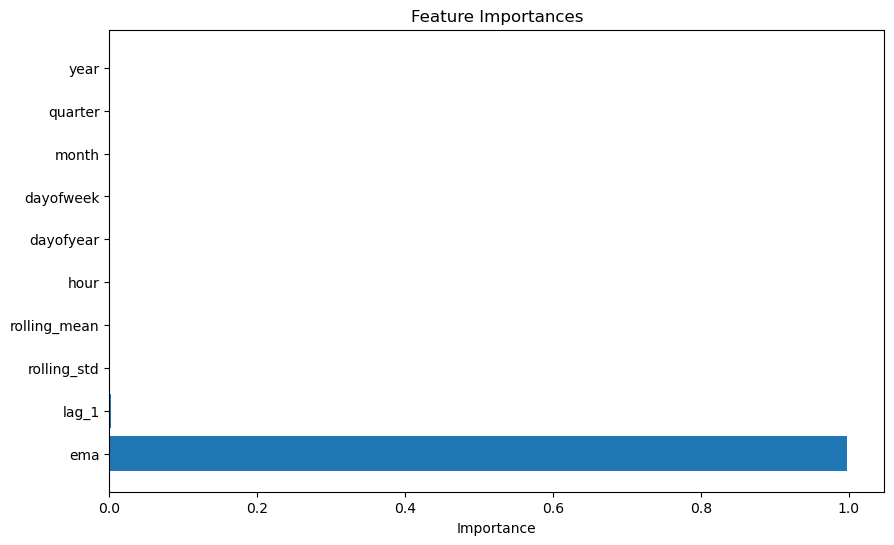

In [51]:
# Get feature importances
feature_importances = best_rf_model.feature_importances_

# Create a DataFrame to display feature importances
importance_df = pd.DataFrame({'Feature': FEATURES, 'Importance': feature_importances})
importance_df = importance_df.sort_values(by='Importance', ascending=False)

# Plot feature importances
import matplotlib.pyplot as plt
plt.figure(figsize=(10, 6))
plt.barh(importance_df['Feature'], importance_df['Importance'])
plt.xlabel('Importance')
plt.title('Feature Importances')
plt.show()

In [52]:
from sklearn.metrics import mean_absolute_error,mean_squared_error, mean_absolute_percentage_error

mse_rf = mean_squared_error(y_test, rf_predictions)
mae_rf = mean_absolute_error(y_test, rf_predictions)
mape_rf = mean_absolute_percentage_error(y_test, rf_predictions)
rmse_rf = np.sqrt(mse_rf)

print("Mean Absolute Error(mae): ", mae_rf)
print(f'Mean Absolute Percentage Error (MAPE) : {mape_rf*100:.2f}%')
print("Mean Squared Error(mse): ", mse_rf)
print("Root Mean Squared Error(rmse) :", rmse_rf)

compare_result_df = pd.DataFrame({'Actual': y_test, 'Predicted': rf_predictions})
print("compare_result_df : ", compare_result_df )

Mean Absolute Error(mae):  1.3339258069813105
Mean Absolute Percentage Error (MAPE) : 1.19%
Mean Squared Error(mse):  40.69307880000039
Root Mean Squared Error(rmse) : 6.379112696919564
compare_result_df :                                 Actual   Predicted
_time                                            
2024-01-30 00:15:00+00:00  437.805570  437.732282
2024-01-30 00:30:00+00:00  437.878258  438.151771
2024-01-30 00:45:00+00:00  437.171650  437.441602
2024-01-30 01:00:00+00:00  430.701170  430.976739
2024-01-30 01:15:00+00:00  426.946037  427.711779
...                               ...         ...
2024-03-23 15:00:00+00:00  147.389738  145.308345
2024-03-23 15:15:00+00:00   89.052470   28.590224
2024-03-23 15:30:00+00:00  155.422397  145.227961
2024-03-23 15:45:00+00:00  160.554765  157.290810
2024-03-23 16:00:00+00:00  174.335259  171.748985

[5152 rows x 2 columns]


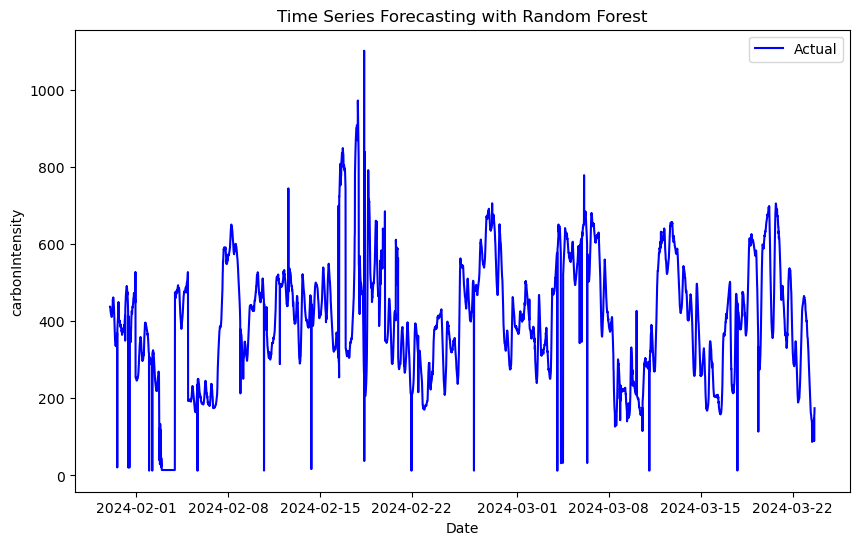

In [53]:
# Test Set plotting
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['carbonIntensity'], label='Actual', color='blue')
plt.title('Time Series Forecasting with Random Forest')
plt.xlabel('Date')
plt.ylabel('carbonIntensity')
plt.legend()
plt.show()

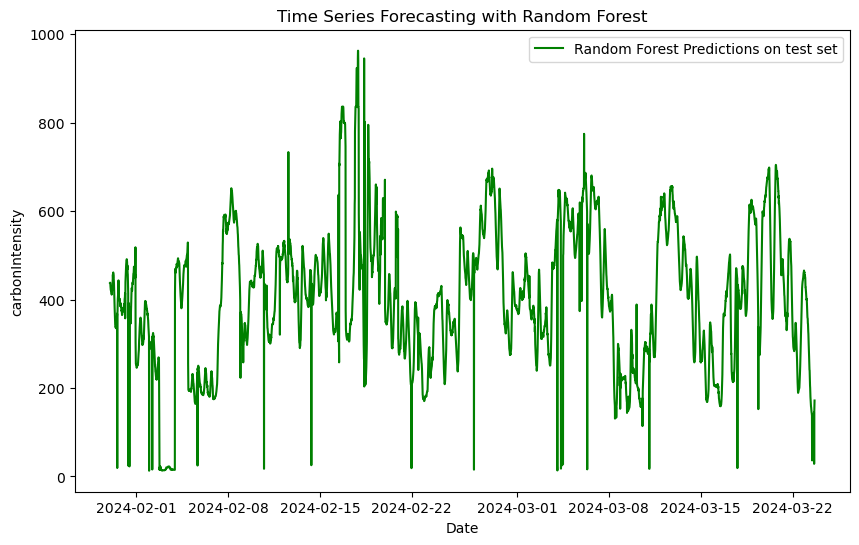

In [54]:
# Test Prediction plotting
plt.figure(figsize=(10, 6))
plt.plot(test.index, rf_predictions, label='Random Forest Predictions on test set', color='green')
plt.title('Time Series Forecasting with Random Forest')
plt.xlabel('Date')
plt.ylabel('carbonIntensity')
plt.legend()
plt.show()

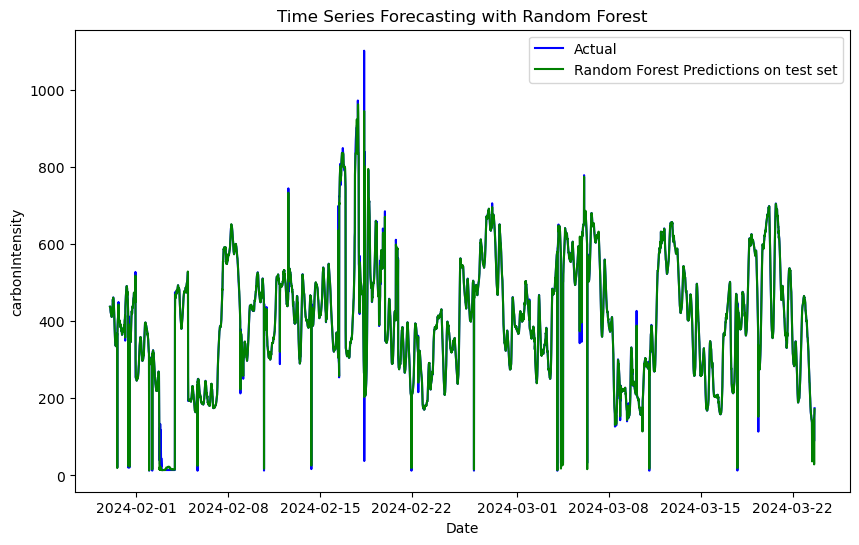

In [55]:
# Mixed plotting or Test Set and Test Prediction Set
plt.figure(figsize=(10, 6))
plt.plot(test.index, test['carbonIntensity'], label='Actual', color='blue')
plt.plot(test.index, rf_predictions, label='Random Forest Predictions on test set', color='green')
plt.title('Time Series Forecasting with Random Forest')
plt.xlabel('Date')
plt.ylabel('carbonIntensity')
plt.legend()
plt.show()

In [56]:
import warnings

# Ignore all warnings
warnings.filterwarnings("ignore")


#Predicting the Future
"""
Retraining on all data
"""

combined_df = pd.concat([train, test], axis=0)

#Optional: we are not dealing with index of combined df anyways
combined_df = combined_df.reset_index(drop=True)


FEATURES = ['ema']
TARGET = 'carbonIntensity'

X_all = combined_df[FEATURES]
y_all = combined_df[TARGET]


best_rf_model.fit(X_all, y_all)

print("Training on both train and test set done")

Training on both train and test set done


In [57]:
X_all

,ema
0,299.797186
1,300.793906
2,300.468177
3,300.109109
4,300.632560
...,...
34345,146.459059
34346,100.533788
34347,144.444675
34348,157.332747


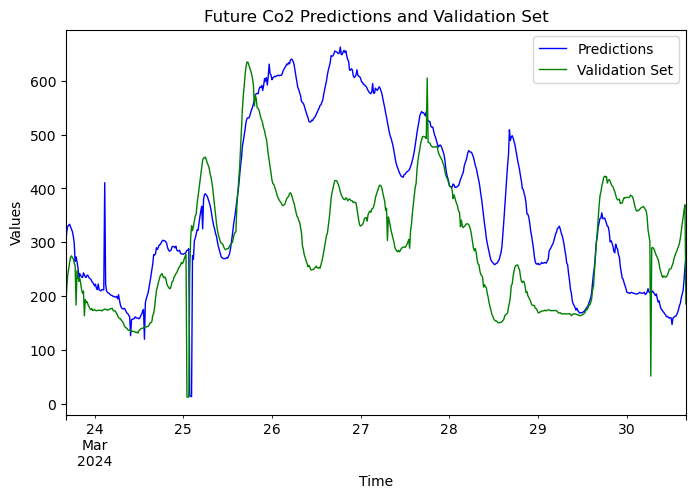

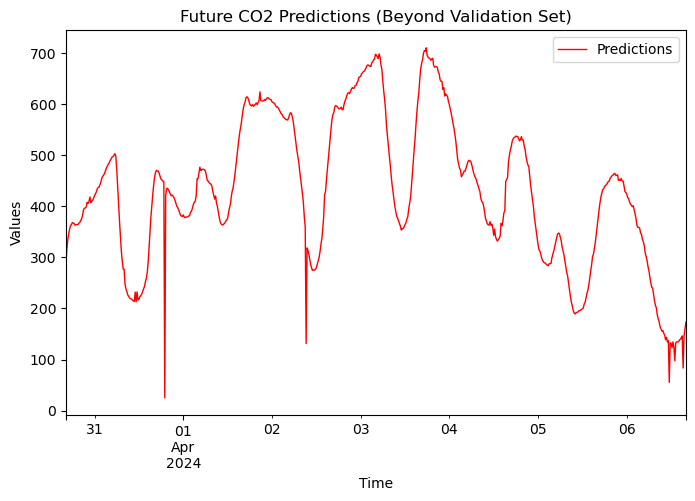

In [58]:
# print("Predicting for 14 time points in future and validating against validation set")
# Create a date range for the next 14 days with 15-minute intervals
start_date = validation.index[0]
end_date = validation.index[-1]
end_date_2 = end_date + pd.Timedelta(minutes=15 * 672)
next_7_days_index = pd.date_range(start=start_date, end=end_date, freq='15T')
next_14_days_index = pd.date_range(start=start_date, end=end_date_2, freq='15T')



next_7_days_features = X_all.iloc[-1 * len(next_7_days_index):, :] # Getting 7 days features for X_all ( only EMA )
next_14_days_features = X_all.iloc[-1 * len(next_14_days_index):, :] # Getting 14 days features for X_all ( only EMA )

# print("next_7_days_features  : ", next_7_days_features)
predictions = []

# Iterate through each time step and make predictions
for i in range(len(next_14_days_index)):
    # Select the most recent observation for the current time step
    current_observation = next_14_days_features.iloc[i:i+1]

    # Make a one-step prediction using the trained Random Forest model
    rf_one_step_prediction = best_rf_model.predict(current_observation)

    # Append the prediction to the list
    predictions.append(rf_one_step_prediction[0])


# Create a DataFrame to store the predictions
predictions_df = pd.DataFrame(data=predictions, index=next_14_days_index, columns=['Co2_prediction'])


# Plotting predictions
predictions_df['Co2_prediction'][:672].plot(figsize=(8, 5),
                                              color='blue',
                                              label='Predictions',
                                              ms=1,
                                              lw=1)

# Plotting validation set data
validation[TARGET].plot(figsize=(8, 5),
                        color='green',
                        label='Validation Set',
                        ms=1,
                        lw=1)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Future Co2 Predictions and Validation Set')

# Adding legend
plt.legend()

# Display the plot
plt.show()


# Plotting predictions for points beyond the first 672
predictions_df['Co2_prediction'][672:].plot(figsize=(8, 5),
                                              color='red',
                                              label='Predictions',
                                              ms=1,
                                              lw=1)

# Adding labels and title
plt.xlabel('Time')
plt.ylabel('Values')
plt.title('Future CO2 Predictions (Beyond Validation Set)')

# Adding legend
plt.legend()

# Display the plot
plt.show()

In [59]:
predictions_df

,Co2_prediction
2024-03-23 16:15:00+00:00,303.086146
2024-03-23 16:30:00+00:00,320.939310
2024-03-23 16:45:00+00:00,329.573359
2024-03-23 17:00:00+00:00,331.376020
2024-03-23 17:15:00+00:00,333.313864
...,...
2024-04-06 15:00:00+00:00,146.352552
2024-04-06 15:15:00+00:00,83.283312
2024-04-06 15:30:00+00:00,146.238244
2024-04-06 15:45:00+00:00,159.472995


In [ ]:
predictions_df.to_csv('predictions.csv', index=True)

In [60]:
mse_rf = mean_squared_error(validation[TARGET], predictions[:672])
mae_rf = mean_absolute_error(validation[TARGET], predictions[:672])
mape_rf = mean_absolute_percentage_error(validation[TARGET], predictions[:672])
rmse_rf = np.sqrt(mse_rf)


print("Mean Absolute Error(mae): ", mae_rf)
print(f'Mean Absolute Percentage Error (MAPE) : {mape_rf*100:.2f}%')
print("Mean Squared Error(mse): ", mse_rf)
print("Root Mean Squared Error(rmse) :", rmse_rf)

Mean Absolute Error(mae):  114.68196185493404
Mean Absolute Percentage Error (MAPE) : 50.95%
Mean Squared Error(mse):  20496.65472873609
Root Mean Squared Error(rmse) : 143.16652796214655
